In [1]:
import pandas as pd
import numpy as np

import torch

from zlib import crc32
import warnings


warnings.filterwarnings("ignore") 

In [7]:
label_to_number = {
    "NEUTRAL": 0,
    "SLIGHTLY_TOXIC": 1,
    "TOXIC": 2,
    "EXTREMELY_TOXIC": 3,
    "N_A": 0
}


def take_average(annotations):
    sum = 0
    count = 0
    for annotation in annotations:
        if annotation != "N_A":
            sum += label_to_number[annotation]
            count += 1
    if count == 0:
        return -1
    label = int(sum/count)
    if label > 2:
        label = 2
    return label

In [38]:
from pymongo import MongoClient
from torch_geometric.data import Data


count = 2000
client = MongoClient(
f'mongodb://localhost:27017')
mydb = client.get_database("toxic_games")

collection = mydb.get_collection("games")


steamid_to_index_graph = {}
steamid_to_index_messages = {}
index_to_toxicities = {}


source = []
target = []
steamid2_to_index_graph = {}
features = []
all_features = []
graphs_train = []
graphs_validation = []
graph_labels = []
nodes = []

def get_team(players, player):
    if player not in players:
        return 0
    if players[player]["team"] == "Blue":
        return 1
    else: 
        return 2

for idx, item in enumerate(collection.find({"lang" : "Language.ENGLISH", "problem": {"$exists": False}}).limit(count).allow_disk_use(True)):
    if idx % 100 == 0:
        print(idx)
    logdata = item["log"]["events"]
    players = item["log"]["players"]

    for index, event in enumerate(logdata):
        nodes.append([1 if event["kill"] else 0,1 if event["chargeUsed"] else 0,1 if event["medicDrop"] else 0,1 if event["message"] else 0,1 if event["capture"] else 0])
        for index2, event2 in enumerate(logdata):
            if index == index2 or (event["second"] - event2["second"] > 10 or event["second"] - event2["second"] < 0):
                continue
            if event["attacker"] == event2["attacker"]:
                source.append(index)
                target.append(index2)
                features.append([1, get_team(players, event["attacker"])])
            elif event["victim"] and event["victim"] == event2["victim"]:
                source.append(index)
                target.append(index2)
                features.append([0, get_team(players, event["victim"])])
    

    players = list(set(target + source))
    if (len(players) == 0):
        source = []
        target = []
        nodes = []
        features = []
        steamid2_to_index_graph = {}
        continue
    
    all_features.append(features)
    toxic = 0
    score = 0
    toxic = take_average(item["annotation"])
    if toxic == -1:
        source = []
        target = []
        nodes = []
        features = []
        steamid2_to_index_graph = {}
        continue
    graph_labels.append(toxic)
    x = torch.tensor(nodes, dtype=torch.float32)
    if item["type"] == "train":
        graphs_train.append(Data(x=x, edge_attr=torch.tensor(features, dtype=torch.float32), edge_index=torch.tensor([source, target], dtype=torch.long),y=torch.Tensor([toxic]).to(torch.long)))
    else:
        graphs_validation.append(Data(x=x, edge_attr=torch.tensor(features, dtype=torch.float32), edge_index=torch.tensor([source, target], dtype=torch.long),y=torch.Tensor([toxic]).to(torch.long)))
    source = []
    nodes=[]
    target = []
    features = []
    steamid2_to_index_graph = {}

0
100
200
300
400
500
600


In [39]:
pd.DataFrame(graph_labels).value_counts().to_frame()

,count
0,
0,505
1,111
2,56


In [40]:
len(graphs_validation)

511

In [41]:
len(graphs_train)

161

In [42]:
torch.manual_seed(12345)
#dataset = graphs
#split = int(len(dataset)*0.7)
split = int(len(graphs_validation)*0.7)
trainy = graphs_train.copy()
trainy.extend(graphs_validation[:split])
train_dataset = trainy#dataset[:split]

remaining_dataset = graphs_validation[split:]#dataset[split:]
remaining_split = int(len(remaining_dataset)*0.5)

validation_dataset = remaining_dataset[:remaining_split]
test_dataset = remaining_dataset[remaining_split:]
print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(validation_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 518
Number of validation graphs: 77
Number of test graphs: 77


In [43]:
val_y = list(map(lambda x: x.y.item(), validation_dataset))
pd.DataFrame(val_y).value_counts().to_frame()

,count
0,
0,62
1,11
2,4


In [44]:
from torch_geometric.loader import DataLoader
from torch_geometric.loader.imbalanced_sampler import ImbalancedSampler

train_loader = DataLoader(train_dataset, sampler=ImbalancedSampler(train_dataset), batch_size=16)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 16
DataBatch(x=[4938, 5], edge_index=[2, 1429], edge_attr=[1429, 2], y=[16], batch=[4938], ptr=[17])

Step 2:
Number of graphs in the current batch: 16
DataBatch(x=[4384, 5], edge_index=[2, 1182], edge_attr=[1182, 2], y=[16], batch=[4384], ptr=[17])

Step 3:
Number of graphs in the current batch: 16
DataBatch(x=[4885, 5], edge_index=[2, 1586], edge_attr=[1586, 2], y=[16], batch=[4885], ptr=[17])

Step 4:
Number of graphs in the current batch: 16
DataBatch(x=[5229, 5], edge_index=[2, 1573], edge_attr=[1573, 2], y=[16], batch=[5229], ptr=[17])

Step 5:
Number of graphs in the current batch: 16
DataBatch(x=[4634, 5], edge_index=[2, 1392], edge_attr=[1392, 2], y=[16], batch=[4634], ptr=[17])

Step 6:
Number of graphs in the current batch: 16
DataBatch(x=[6003, 5], edge_index=[2, 1840], edge_attr=[1840, 2], y=[16], batch=[6003], ptr=[17])

Step 7:
Number of graphs in the current batch: 16
DataBatch(x=[5786, 5], edge_index=[2, 1760], edge_attr=[

In [45]:
from torch_geometric.utils import degree
max_degree = -1
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    max_degree = max(max_degree, int(d.max()))

# Compute the in-degree histogram tensor
deg = torch.zeros(max_degree + 1, dtype=torch.long)
for data in train_dataset:
    d = degree(data.edge_index[1], num_nodes=data.num_nodes, dtype=torch.long)
    deg += torch.bincount(d, minlength=deg.numel())

In [46]:

from torch_geometric.nn import BatchNorm, PNAConv, global_add_pool
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ModuleList, ReLU, Sequential, Dropout
from torch.optim.lr_scheduler import ReduceLROnPlateau
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()

        aggregators = ['mean', 'min', 'max', 'std']
        scalers = ['identity', 'amplification', 'attenuation']

        self.convs = ModuleList()
        self.batch_norms = ModuleList()
        for _ in range(2):
            conv = PNAConv(in_channels=5, out_channels=5,
                           aggregators=aggregators, scalers=scalers, deg=deg,
                           edge_dim=2, towers=5, pre_layers=1, post_layers=1,
                           divide_input=False)
            self.convs.append(conv)
            self.batch_norms.append(BatchNorm(5))

        self.mlp = Sequential(Linear(5, 5), ReLU(), Linear(5, 10), ReLU(),
                              Linear(10, 3))

    def forward(self, x, edge_index, edge_attr, batch):
        x = x#self.node_emb(x.squeeze())
        #edge_attr = self.edge_emb(edge_attr)

        for conv, batch_norm in zip(self.convs, self.batch_norms):
            x = F.relu(batch_norm(conv(x, edge_index, edge_attr)))

        x = global_add_pool(x, batch)
        return self.mlp(x)

Epoch: 01, Loss: 3.7137, Val: 0.8292, Test: 0.9064 ROC: 0.5150
Epoch: 02, Loss: 2.1887, Val: 0.9613, Test: 0.9596 ROC: 0.5540
Epoch: 03, Loss: 1.5955, Val: 1.3339, Test: 1.3366 ROC: 0.5278
Epoch: 04, Loss: 1.4581, Val: 1.4534, Test: 1.4540 ROC: 0.5370
Epoch: 05, Loss: 1.2910, Val: 1.3476, Test: 1.3751 ROC: 0.5423
Epoch: 06, Loss: 1.4049, Val: 1.3023, Test: 1.2814 ROC: 0.5440
Epoch: 07, Loss: 1.2466, Val: 1.3908, Test: 1.4159 ROC: 0.5332
Epoch: 08, Loss: 1.2595, Val: 1.3089, Test: 1.2909 ROC: 0.5519
Epoch: 09, Loss: 1.1721, Val: 1.2783, Test: 1.2915 ROC: 0.5497
Epoch: 10, Loss: 1.2937, Val: 1.3473, Test: 1.3381 ROC: 0.5462
Epoch: 11, Loss: 1.2028, Val: 1.3113, Test: 1.3015 ROC: 0.5336
Epoch: 12, Loss: 1.1739, Val: 1.2354, Test: 1.2330 ROC: 0.5389
Epoch: 13, Loss: 1.1219, Val: 1.2569, Test: 1.2627 ROC: 0.5499
Epoch: 14, Loss: 1.1157, Val: 1.2799, Test: 1.2724 ROC: 0.5460
Epoch: 15, Loss: 1.1559, Val: 1.3044, Test: 1.2850 ROC: 0.5294
Epoch: 16, Loss: 1.1298, Val: 1.2610, Test: 1.2490 ROC:

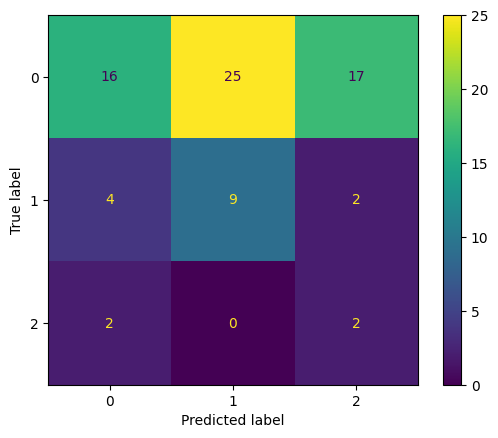

In [56]:
from sklearn.metrics import ConfusionMatrixDisplay, auc, confusion_matrix, f1_score, precision_recall_curve, precision_score, recall_score
from sklearn.metrics import roc_auc_score, accuracy_score
torch.manual_seed(12345)

loss_fn = torch.nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10,
                              min_lr=0.00001)

best_loss = np.inf

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        loss = loss_fn(out, data.y.to(torch.long))
        loss.backward()
        total_loss += loss.item() * data.num_graphs
        optimizer.step()
    
    return total_loss / len(train_loader.dataset)


@torch.no_grad()
def test(loader):
    model.eval()
    total_error = 0
    total_true = []
    total_score = []
    total_pred = []
    for data in loader:
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_attr, data.batch)
        total_error += loss_fn(out, data.y.to(torch.long)).item() * data.num_graphs
        total_true.extend(data.y.tolist())
        total_score.extend(out.softmax(dim=1).tolist())
        total_pred.extend(out.softmax(dim=1).argmax(dim=1).tolist())

    roc = roc_auc_score(total_true, total_score,average="macro", multi_class='ovo')
    cm = confusion_matrix(total_true, total_pred)
    return total_error / len(loader.dataset), roc, cm


for epoch in range(1, 301):
    loss = train(epoch)
    val_loss, roc, cm = test(validation_loader)
    test_loss, test_roc, test_cm = test(test_loader)
    scheduler.step(val_loss)
    if epoch >= 5:
        if val_loss < best_loss:
            best_loss = val_loss
            best_roc = test_roc
            best_cm = test_cm
            epoch_count = 0
        else:
            epoch_count += 1
        if epoch_count >= 20:
            break
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Val: {val_loss:.4f}, Test: {test_loss:.4f} ROC: {roc:.4f}')
print(best_roc)
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm)
disp.plot()